# Single Photon Counting with FastCCD and CSXTOOLS

## First some imports, using csxtools

In [1]:
import numpy as np
import tifffile

%matplotlib notebook
from matplotlib import pyplot as plt

from databroker import DataBroker as db

from csxtools.fastccd import phocount
from csxtools import make_panel_plot
from csxtools.utils import get_fastccd_images, get_images_to_3D
from csxtools.ipynb import image_stack_to_movie, show_image_stack
import timeit

## Make a flat image to mask the data

/GPFS/xf23id/users/swilkins/miniconda3/envs/analysis/lib/python3.5/site-packages/IPython/kernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


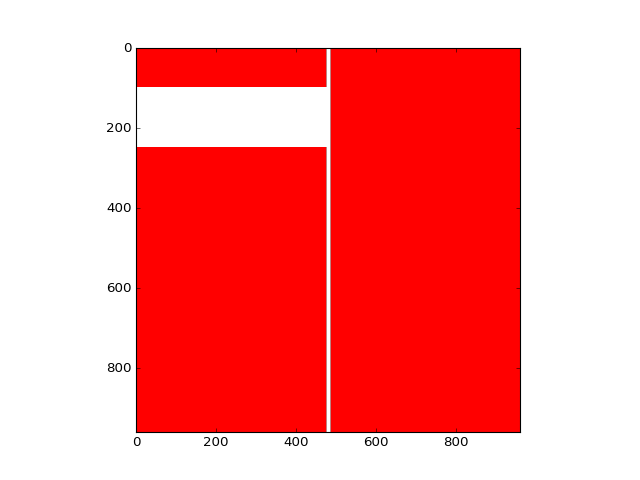

In [2]:
flat = np.ones((960, 960), dtype=np.float32)
flat[100:250,0:(960/2)] = np.nan
flat[:,475:485] = np.nan
plt.figure()
plt.imshow(flat, cmap='prism')

flat = np.rot90(flat)

## Load the data
Using test data from a run at CSX

In [3]:
dark = db[58886]
light = db[58885]
images = get_fastccd_images(light, (dark, None, None), flat=flat)
stack = get_images_to_3D(images)
dark_images = get_fastccd_images(dark, (dark, None, None), flat=flat)
dark_stack = get_images_to_3D(dark_images)

## Check the data

<IPython.core.display.Javascript object>


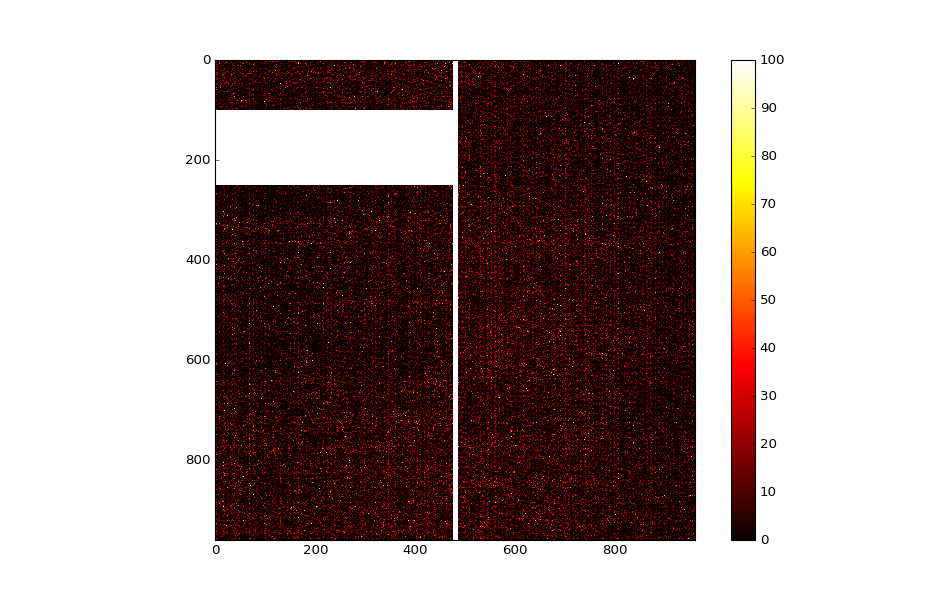

In [4]:
plt.figure()
plt.imshow(stack[0], vmin=0, vmax=100, cmap='hot', interpolation='none')
plt.colorbar()

<IPython.core.display.Javascript object>


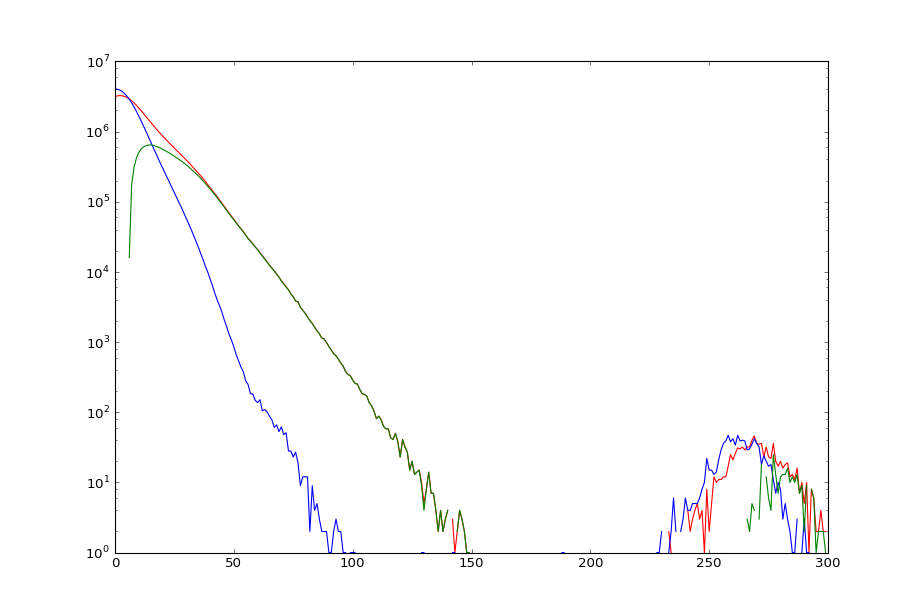

In [5]:
h = np.histogram(stack.ravel(), bins=300, range=(0, 300))
h_b = np.histogram(dark_stack.ravel(), bins=300, range=(0, 300))
fig, ax = plt.subplots()
ax.semilogy(h[1][:-1], h[0], 'r-')
ax.semilogy(h_b[1][:-1], h_b[0], 'b-')
ax.semilogy(h_b[1][:-1], h[0] - h_b[0], 'g-')

## Flatfield Correction

Now generate a flatfield correction based on the mean per column. 

In [11]:
c = phocount.photon_count(stack, (30,100), (75, 120), (3, 12), 3, True)
inti = c[0][:,:,480:]
stdi = c[1][:,:,480:]
#inti[:,:,0::10] = np.nan
#inti[:,:,9::10] = np.nan
ff = np.nanmean(inti, axis=(0,2))
ffstd = np.nanstd(inti, axis=(0,2))
ffn = np.nansum(inti > 0, axis=(0,2))
ggstd = np.nanmean(stdi, axis=(0,2))

/GPFS/xf23id/users/swilkins/miniconda3/envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/GPFS/xf23id/users/swilkins/miniconda3/envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/GPFS/xf23id/users/swilkins/miniconda3/envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


<IPython.core.display.Javascript object>


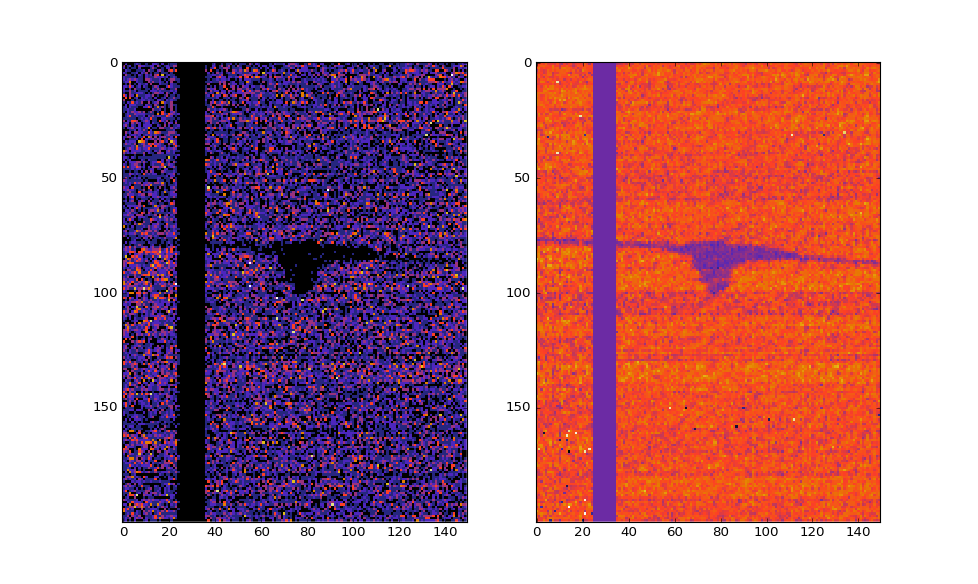

In [12]:
fig, ax = plt.subplots(1,2)
cax = ax[0].imshow(np.nansum(c[0] > 0, axis=0)[400:600,450:600], cmap='CMRmap', interpolation='none')
cax = ax[1].imshow(np.nansum(stack, axis=0)[400:600,450:600], cmap='CMRmap', interpolation='none')
#cbar = fig.colorbar(cax)

<IPython.core.display.Javascript object>


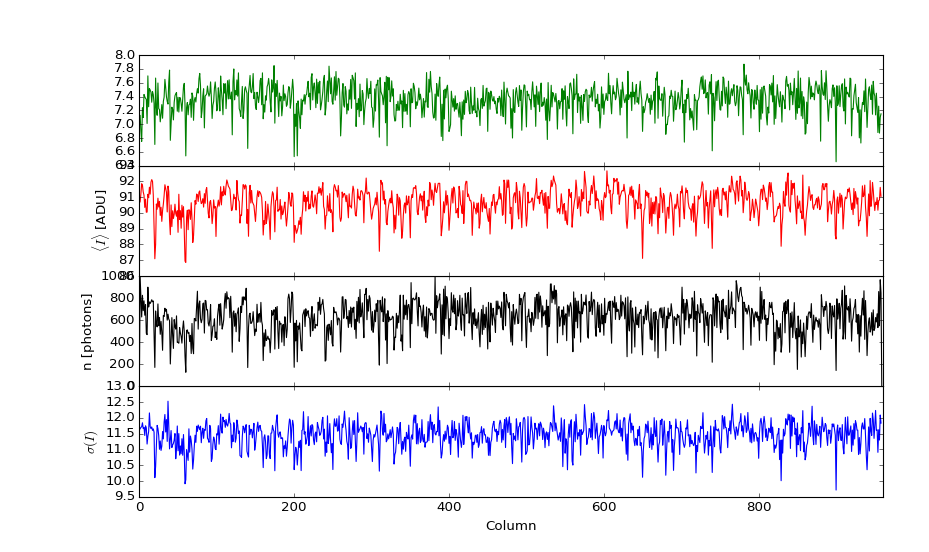

In [13]:
fig = plt.figure()
ax = make_panel_plot(n=4, fig=fig)

ax[3].plot(ggstd, 'g')
ax[2].plot(ff, 'r-')
ax[1].plot(ffn, 'k-')
ax[0].plot(ffstd, 'b-')

ax[2].set_ylabel(r'$\leftangle I \rightangle$ [ADU]')
ax[2].set_title('Results by column ')
ax[1].set_ylabel('n [photons]')
ax[0].set_ylabel('$\sigma (I)$')
ax[0].set_xlabel('Column')

for a in ax:
    a.set_xlim((0,960))

<IPython.core.display.Javascript object>


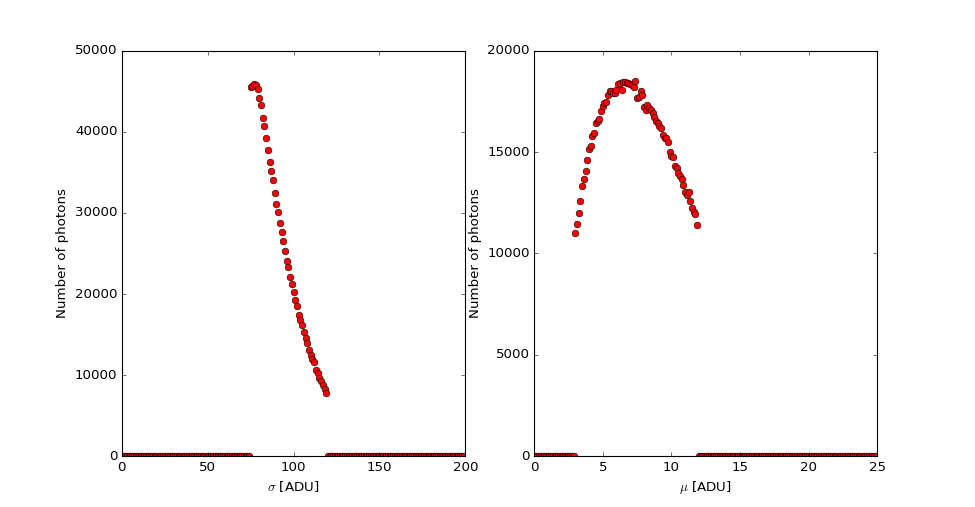

In [14]:
hist_std = np.histogram(c[1], bins=200, range=(0,25))
hist_sum = np.histogram(c[0], bins=200, range=(0,200))
fig, ax = plt.subplots(1,2)
ax[0].plot(hist_sum[1][:-1], hist_sum[0], 'ro')
ax[0].set_xlabel('$\sigma$ [ADU]')
ax[0].set_ylabel('Number of photons')
ax[1].plot(hist_std[1][:-1], hist_std[0], 'ro')
ax[1].set_xlabel('$\mu$ [ADU]')
ax[1].set_ylabel('Number of photons')

In [15]:
import csxtools
csxtools.__version__

'0.1.9'